In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T

spark = SparkSession.builder.getOrCreate()

* Rank records
* Identify the top/bottom record according to a set of conditions
* Get a value from a previous observation in a table (e.g., using our temperature data frame from chapter 9 and asking “What was the temperature yesterday?”)
* Build trended features (i.e., features that summarize past observations, such as the average of the observations for the previous week) you

A windows function always keeps the dimension of the data frame intact.

# Simple Window Function


In [2]:
path = "/".join("\sparkdata\DataAnalysisWithPythonAndPySpark-Data\gsod_noaa".split("\\"))

In [3]:
from functools import reduce
gsod = (
    reduce(
        lambda x, y: x.unionByName(y, allowMissingColumns=True),
        [
            spark.read.parquet(path+f"/gsod{year}.parquet")
            for year in range(2010, 2021)
        ],
    )
    .dropna(subset=["year", "mo", "da", "temp"])
    .where(F.col("temp") != 9999.9)
    .drop("date")
)

Getting coldest days and places 

In [11]:
coldest_temp = gsod.groupBy(F.col("year")).agg(F.min(F.col("temp")).alias("temp"))

In [8]:
coldest_temp.show()

+----+-------+
|year|minTemp|
+----+-------+
|2010| -110.7|
|2011| -106.8|
|2012| -113.5|
|2013| -110.7|
|2014| -110.5|
|2015| -110.2|
|2016| -111.7|
|2017| -114.7|
|2018| -113.5|
|2019| -114.7|
|2020| -105.0|
+----+-------+



In [12]:
coldest_when = gsod.join(
    coldest_temp, how="left_semi", on=["year", "temp"]
    ).select("stn", "year", "mo", "da", "temp")
coldest_when.orderBy("year", "mo", "da").show()

+------+----+---+---+------+
|   stn|year| mo| da|  temp|
+------+----+---+---+------+
|896060|2010| 06| 03|-110.7|
|896060|2011| 05| 19|-106.8|
|896060|2012| 06| 11|-113.5|
|895770|2013| 07| 31|-110.7|
|896060|2014| 08| 20|-110.5|
|895360|2015| 07| 12|-110.2|
|896060|2015| 08| 21|-110.2|
|896060|2015| 08| 27|-110.2|
|896060|2016| 07| 11|-111.7|
|896250|2017| 06| 20|-114.7|
|896060|2018| 08| 27|-113.5|
|895770|2019| 06| 15|-114.7|
|896060|2020| 08| 11|-105.0|
|896250|2020| 08| 13|-105.0|
+------+----+---+---+------+



A self-join may be slow and make the code more complex.

#### Creating a window function to get the same result

comparison with split-apply-combine:
* instead of split: _partition_
* instead of applying, we _select_ values _over the window_
* combine/uion is implicit in a window function

Window functions apply over a window of data split according to the values on a column.
Each split, called a partition, gets the window function applied to each of its
records as if they were independent data frames. The result then gets unioned back
into a single data frame.

In [13]:
from pyspark.sql.window import Window

by_year = Window.partitionBy("year") ## can be more than one column, just add more columns names.

print(by_year)

The WindowSpec object instructs the windows application to split the data frame according to the values in the _year_ column

In [15]:
(gsod
    .withColumn("min_temp", F.min("temp").over(by_year))
    .where("temp = min_temp")
    .select("year", "mo", "da", "stn", "temp")
    .orderBy("year", "mo", "da")
.show())

+----+---+---+------+------+
|year| mo| da|   stn|  temp|
+----+---+---+------+------+
|2010| 06| 03|896060|-110.7|
|2011| 05| 19|896060|-106.8|
|2012| 06| 11|896060|-113.5|
|2013| 07| 31|895770|-110.7|
|2014| 08| 20|896060|-110.5|
|2015| 07| 12|895360|-110.2|
|2015| 08| 21|896060|-110.2|
|2015| 08| 27|896060|-110.2|
|2016| 07| 11|896060|-111.7|
|2017| 06| 20|896250|-114.7|
|2018| 08| 27|896060|-113.5|
|2019| 06| 15|895770|-114.7|
|2020| 08| 11|896060|-105.0|
|2020| 08| 13|896250|-105.0|
+----+---+---+------+------+



the number of records in the data frame does not change.
Although min() is an aggregate function, since it’s applied with the over() method,
every record in the window has the minimum value appended

# Ranking and analytical functions

In [6]:
path = "/".join("\sparkdata\DataAnalysisWithPythonAndPySpark-Data\window".split("\\"))

In [10]:
gsod_light = spark.read.parquet(path+"/gsod_light.parquet")

In [11]:
gsod_light.show()

+------+----+---+---+----+----------+
|   stn|year| mo| da|temp|count_temp|
+------+----+---+---+----+----------+
|994979|2017| 12| 11|21.3|        21|
|998012|2017| 03| 02|31.4|        24|
|719200|2017| 10| 09|60.5|        11|
|917350|2018| 04| 21|82.6|         9|
|076470|2018| 06| 07|65.0|        24|
|996470|2018| 03| 12|55.6|        12|
|041680|2019| 02| 19|16.1|        15|
|949110|2019| 11| 23|54.9|        14|
|998252|2019| 04| 18|44.7|        11|
|998166|2019| 03| 20|34.8|        12|
+------+----+---+---+----+----------+



## Ranking functions

Ranking functions rank based in the value of a field &rarr; we need to order the values within a window

In [12]:
from pyspark.sql.window import Window

temp_per_month_asc = Window.partitionBy("mo").orderBy("count_temp")

### Simple Ranking

nonconsecutive ranks for each record: when multiple records tie for a rank, the next one will be offset by the number of ties (two values are at first &rarr; the following one will be third)

In [13]:
gsod_light.withColumn(
    "rank_tpm", F.rank().over(temp_per_month_asc)
).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       3|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



### No ties when ranking: _dense_rank()_

assigns consecutive ranks for records, regardless of ties. (two values are at first &rarr; the following one will be second)

In [18]:
gsod_light.withColumn(
    "rank_tpm", F.dense_rank().over(temp_per_month_asc)
).orderBy(F.col("mo"),F.col("rank_tpm")).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       2|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



### _percent_rank()_

"What percentage of values are equal or lower to the given value?"

In [23]:
temp_each_year = Window.partitionBy("year").orderBy("temp")

gsod_light.withColumn(
    "rank_tpm", F.percent_rank().over(temp_each_year)
).orderBy(F.col("year"),ascending=False).show()

+------+----+---+---+----+----------+------------------+
|   stn|year| mo| da|temp|count_temp|          rank_tpm|
+------+----+---+---+----+----------+------------------+
|041680|2019| 02| 19|16.1|        15|               0.0|
|998166|2019| 03| 20|34.8|        12|0.3333333333333333|
|998252|2019| 04| 18|44.7|        11|0.6666666666666666|
|949110|2019| 11| 23|54.9|        14|               1.0|
|996470|2018| 03| 12|55.6|        12|               0.0|
|076470|2018| 06| 07|65.0|        24|               0.5|
|917350|2018| 04| 21|82.6|         9|               1.0|
|994979|2017| 12| 11|21.3|        21|               0.0|
|998012|2017| 03| 02|31.4|        24|               0.5|
|719200|2017| 10| 09|60.5|        11|               1.0|
+------+----+---+---+----+----------+------------------+



### _ntile()_

divides the window in n equal parts. 

<div>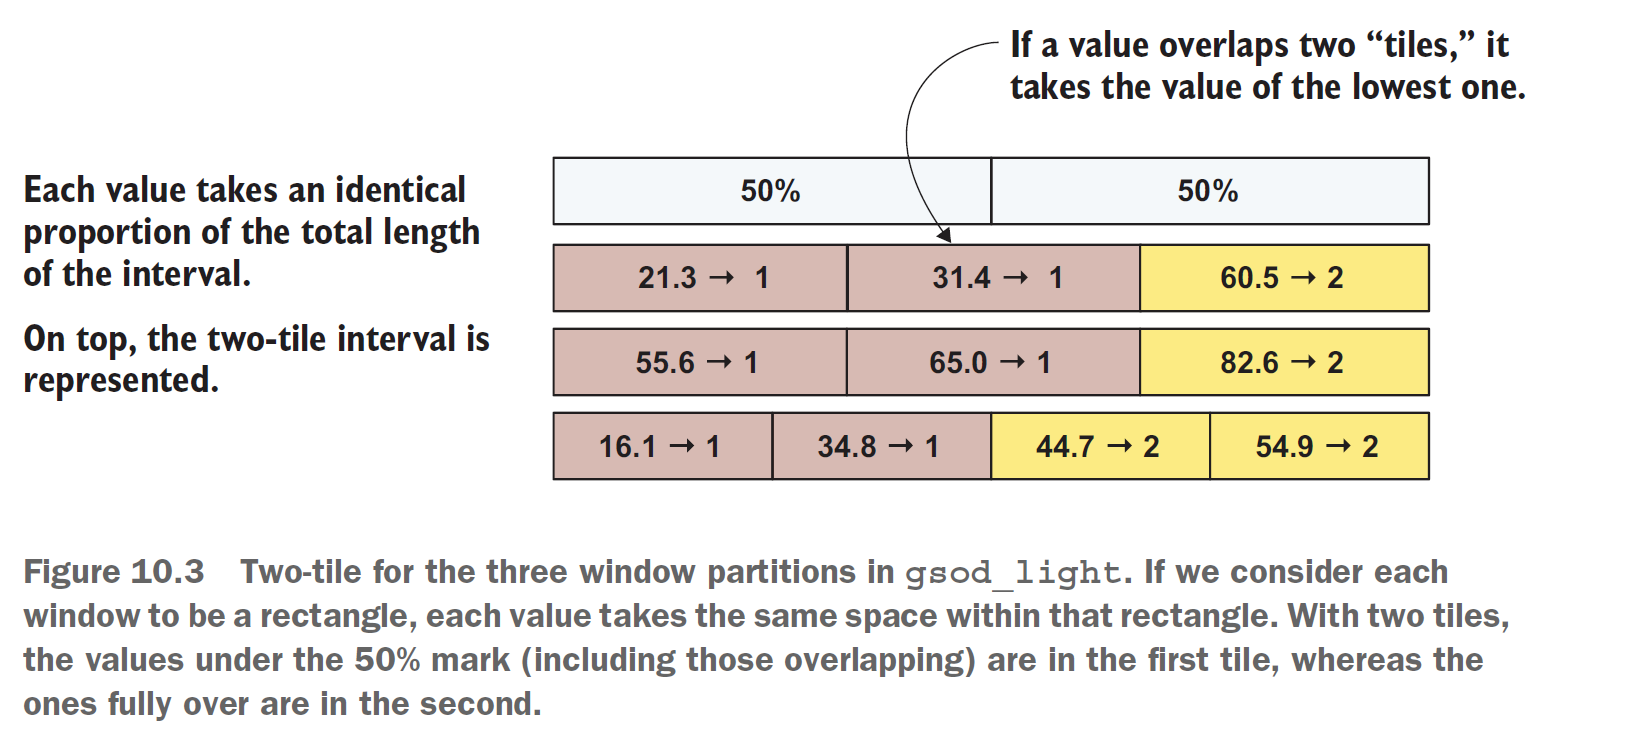</div>

In [24]:
gsod_light.withColumn("rank_tpm", F.ntile(2).over(temp_each_year)).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|994979|2017| 12| 11|21.3|        21|       1|
|998012|2017| 03| 02|31.4|        24|       1|
|719200|2017| 10| 09|60.5|        11|       2|
|996470|2018| 03| 12|55.6|        12|       1|
|076470|2018| 06| 07|65.0|        24|       1|
|917350|2018| 04| 21|82.6|         9|       2|
|041680|2019| 02| 19|16.1|        15|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|949110|2019| 11| 23|54.9|        14|       2|
+------+----+---+---+----+----------+--------+



### _row_number()_

given an ordered window, assign an increasing rank regardless of ties.

In [26]:
gsod_light.withColumn(
    "rank_tpm", F.row_number().over(temp_each_year)
).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|994979|2017| 12| 11|21.3|        21|       1|
|998012|2017| 03| 02|31.4|        24|       2|
|719200|2017| 10| 09|60.5|        11|       3|
|996470|2018| 03| 12|55.6|        12|       1|
|076470|2018| 06| 07|65.0|        24|       2|
|917350|2018| 04| 21|82.6|         9|       3|
|041680|2019| 02| 19|16.1|        15|       1|
|998166|2019| 03| 20|34.8|        12|       2|
|998252|2019| 04| 18|44.7|        11|       3|
|949110|2019| 11| 23|54.9|        14|       4|
+------+----+---+---+----+----------+--------+



### Ordering WindowSpec with orderBy()

_orderBy()_ does not have an ascending parameter as a method on a window, only on a data frame &rarr; need to use the desc() method on the column

In [32]:
temp_per_month_desc = Window.partitionBy("mo").orderBy(
    F.col("count_temp").desc()
)

gsod_light.withColumn(
    "row_number", F.row_number().over(temp_per_month_desc)
).orderBy("mo","count_temp",ascending=[True,False]).show()

+------+----+---+---+----+----------+----------+
|   stn|year| mo| da|temp|count_temp|row_number|
+------+----+---+---+----+----------+----------+
|041680|2019| 02| 19|16.1|        15|         1|
|998012|2017| 03| 02|31.4|        24|         1|
|996470|2018| 03| 12|55.6|        12|         2|
|998166|2019| 03| 20|34.8|        12|         3|
|998252|2019| 04| 18|44.7|        11|         1|
|917350|2018| 04| 21|82.6|         9|         2|
|076470|2018| 06| 07|65.0|        24|         1|
|719200|2017| 10| 09|60.5|        11|         1|
|949110|2019| 11| 23|54.9|        14|         1|
|994979|2017| 12| 11|21.3|        21|         1|
+------+----+---+---+----+----------+----------+



## Analytical functions

to work with time series, for instance, as it gives the opportunity to look at previous and following records.

### Acess previous or following records: _lag()_ and _lead()_

`lag(col,n=1,default=None), lead(col,n=1,default=None)`

value of the n-th record of a column before and after the record we're over. If the record offset by lag/lead falls beyond the boundaries of the window, Spark defaults to _default_

In [33]:
gsod_light.withColumn(
    "previous_temp", F.lag("temp").over(temp_each_year)
).withColumn(
    "previous_temp2", F.lag("temp",2).over(temp_each_year)
).show()

+------+----+---+---+----+----------+-------------+--------------+
|   stn|year| mo| da|temp|count_temp|previous_temp|previous_temp2|
+------+----+---+---+----+----------+-------------+--------------+
|994979|2017| 12| 11|21.3|        21|         NULL|          NULL|
|998012|2017| 03| 02|31.4|        24|         21.3|          NULL|
|719200|2017| 10| 09|60.5|        11|         31.4|          21.3|
|996470|2018| 03| 12|55.6|        12|         NULL|          NULL|
|076470|2018| 06| 07|65.0|        24|         55.6|          NULL|
|917350|2018| 04| 21|82.6|         9|         65.0|          55.6|
|041680|2019| 02| 19|16.1|        15|         NULL|          NULL|
|998166|2019| 03| 20|34.8|        12|         16.1|          NULL|
|998252|2019| 04| 18|44.7|        11|         34.8|          16.1|
|949110|2019| 11| 23|54.9|        14|         44.7|          34.8|
+------+----+---+---+----+----------+-------------+--------------+



### Cumulative distribution _cume\_dist()_


In [34]:
gsod_light.withColumn(
    "percent_rank",F.percent_rank().over(temp_each_year)
).withColumn("cume_dist",F.cume_dist().over(temp_each_year)).show()

+------+----+---+---+----+----------+------------------+------------------+
|   stn|year| mo| da|temp|count_temp|      percent_rank|         cume_dist|
+------+----+---+---+----+----------+------------------+------------------+
|994979|2017| 12| 11|21.3|        21|               0.0|0.3333333333333333|
|998012|2017| 03| 02|31.4|        24|               0.5|0.6666666666666666|
|719200|2017| 10| 09|60.5|        11|               1.0|               1.0|
|996470|2018| 03| 12|55.6|        12|               0.0|0.3333333333333333|
|076470|2018| 06| 07|65.0|        24|               0.5|0.6666666666666666|
|917350|2018| 04| 21|82.6|         9|               1.0|               1.0|
|041680|2019| 02| 19|16.1|        15|               0.0|              0.25|
|998166|2019| 03| 20|34.8|        12|0.3333333333333333|               0.5|
|998252|2019| 04| 18|44.7|        11|0.6666666666666666|              0.75|
|949110|2019| 11| 23|54.9|        14|               1.0|               1.0|
+------+----

# Row and Range boundaries

Build static, growing and unbounded windows

In [35]:
not_ordered = Window.partitionBy("year")
ordered = not_ordered.orderBy("temp")

gsod_light.withColumn(
    "avg_NO", F.avg("temp").over(not_ordered)
).withColumn("avg_O", F.avg("temp").over(ordered)).show()

+------+----+---+---+----+----------+------------------+------------------+
|   stn|year| mo| da|temp|count_temp|            avg_NO|             avg_O|
+------+----+---+---+----+----------+------------------+------------------+
|994979|2017| 12| 11|21.3|        21|37.733333333333334|              21.3|
|998012|2017| 03| 02|31.4|        24|37.733333333333334|             26.35|
|719200|2017| 10| 09|60.5|        11|37.733333333333334|37.733333333333334|
|996470|2018| 03| 12|55.6|        12| 67.73333333333333|              55.6|
|076470|2018| 06| 07|65.0|        24| 67.73333333333333|              60.3|
|917350|2018| 04| 21|82.6|         9| 67.73333333333333| 67.73333333333333|
|041680|2019| 02| 19|16.1|        15|            37.625|              16.1|
|998166|2019| 03| 20|34.8|        12|            37.625|             25.45|
|998252|2019| 04| 18|44.7|        11|            37.625|31.866666666666664|
|949110|2019| 11| 23|54.9|        14|            37.625|            37.625|
+------+----

Spark API documentation says that when ordering is not defined, an unbounded window frame is used by default; When ordering is defined, a growing window frame is used by default.



## Static, growing, unbounded window

<div>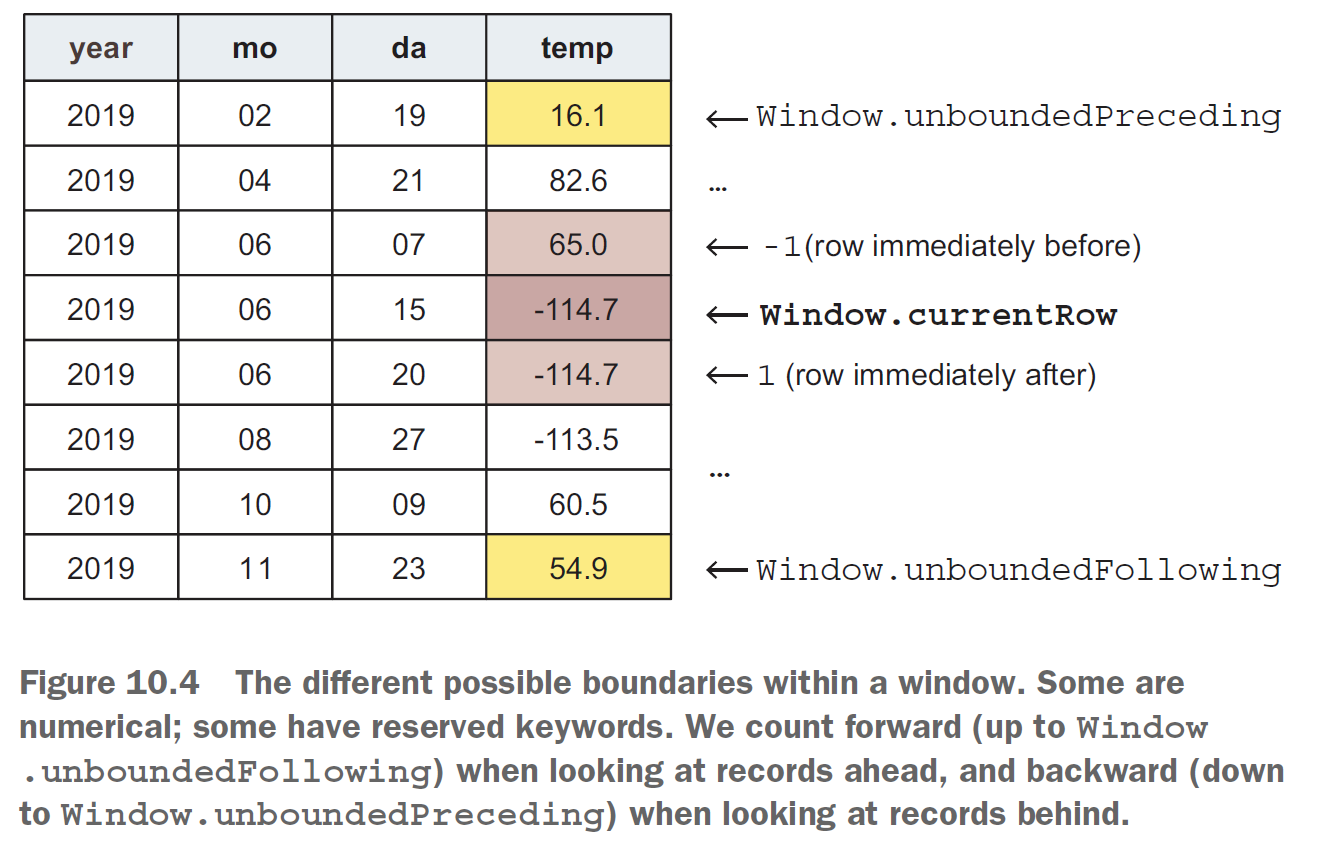</div>



In [36]:
not_ordered = Window.partitionBy("year").rowsBetween(
    Window.unboundedPreceding, Window.unboundedFollowing ## unbounded - every record, from the first to the last, is in the window
)

ordered = not_ordered.orderBy("temp").rangeBetween(
    Window.unboundedPreceding, Window.currentRow ## growing - to the left - every record up to the current row value is included
)

## Range vs rows

Build windows that care about the content of the ordered column, not just its position.

* ranges: dates and time. Range windows only work with numerical columns

In [41]:
gsod_light_p = (
    gsod_light.withColumn("year", F.lit(2019))
    .withColumn(
        "dt",
        F.to_date(
        F.concat_ws("-", F.col("year"), F.col("mo"), F.col("da"))
        ),
    )
    .withColumn("dt_num", F.unix_timestamp("dt"))
)
             
gsod_light_p.show()

+------+----+---+---+----+----------+----------+----------+
|   stn|year| mo| da|temp|count_temp|        dt|    dt_num|
+------+----+---+---+----+----------+----------+----------+
|994979|2019| 12| 11|21.3|        21|2019-12-11|1576022400|
|998012|2019| 03| 02|31.4|        24|2019-03-02|1551484800|
|719200|2019| 10| 09|60.5|        11|2019-10-09|1570579200|
|917350|2019| 04| 21|82.6|         9|2019-04-21|1555804800|
|076470|2019| 06| 07|65.0|        24|2019-06-07|1559865600|
|996470|2019| 03| 12|55.6|        12|2019-03-12|1552348800|
|041680|2019| 02| 19|16.1|        15|2019-02-19|1550534400|
|949110|2019| 11| 23|54.9|        14|2019-11-23|1574467200|
|998252|2019| 04| 18|44.7|        11|2019-04-18|1555545600|
|998166|2019| 03| 20|34.8|        12|2019-03-20|1553040000|
+------+----+---+---+----+----------+----------+----------+



In [42]:

ONE_MONTH_ISH = 30 * 60 * 60 * 24 # or 2_592_000 seconds
one_month_ish_before_and_after = (
    Window.partitionBy("year")
    .orderBy("dt_num")
    .rangeBetween(-ONE_MONTH_ISH, ONE_MONTH_ISH)
)

gsod_light_p.withColumn(
    "avg_count", F.avg("count_temp").over(one_month_ish_before_and_after)
).show()

+------+----+---+---+----+----------+----------+----------+------------------+
|   stn|year| mo| da|temp|count_temp|        dt|    dt_num|         avg_count|
+------+----+---+---+----+----------+----------+----------+------------------+
|041680|2019| 02| 19|16.1|        15|2019-02-19|1550534400|             15.75|
|998012|2019| 03| 02|31.4|        24|2019-03-02|1551484800|             15.75|
|996470|2019| 03| 12|55.6|        12|2019-03-12|1552348800|             15.75|
|998166|2019| 03| 20|34.8|        12|2019-03-20|1553040000|              14.8|
|998252|2019| 04| 18|44.7|        11|2019-04-18|1555545600|10.666666666666666|
|917350|2019| 04| 21|82.6|         9|2019-04-21|1555804800|              10.0|
|076470|2019| 06| 07|65.0|        24|2019-06-07|1559865600|              24.0|
|719200|2019| 10| 09|60.5|        11|2019-10-09|1570579200|              11.0|
|949110|2019| 11| 23|54.9|        14|2019-11-23|1574467200|              17.5|
|994979|2019| 12| 11|21.3|        21|2019-12-11|1576

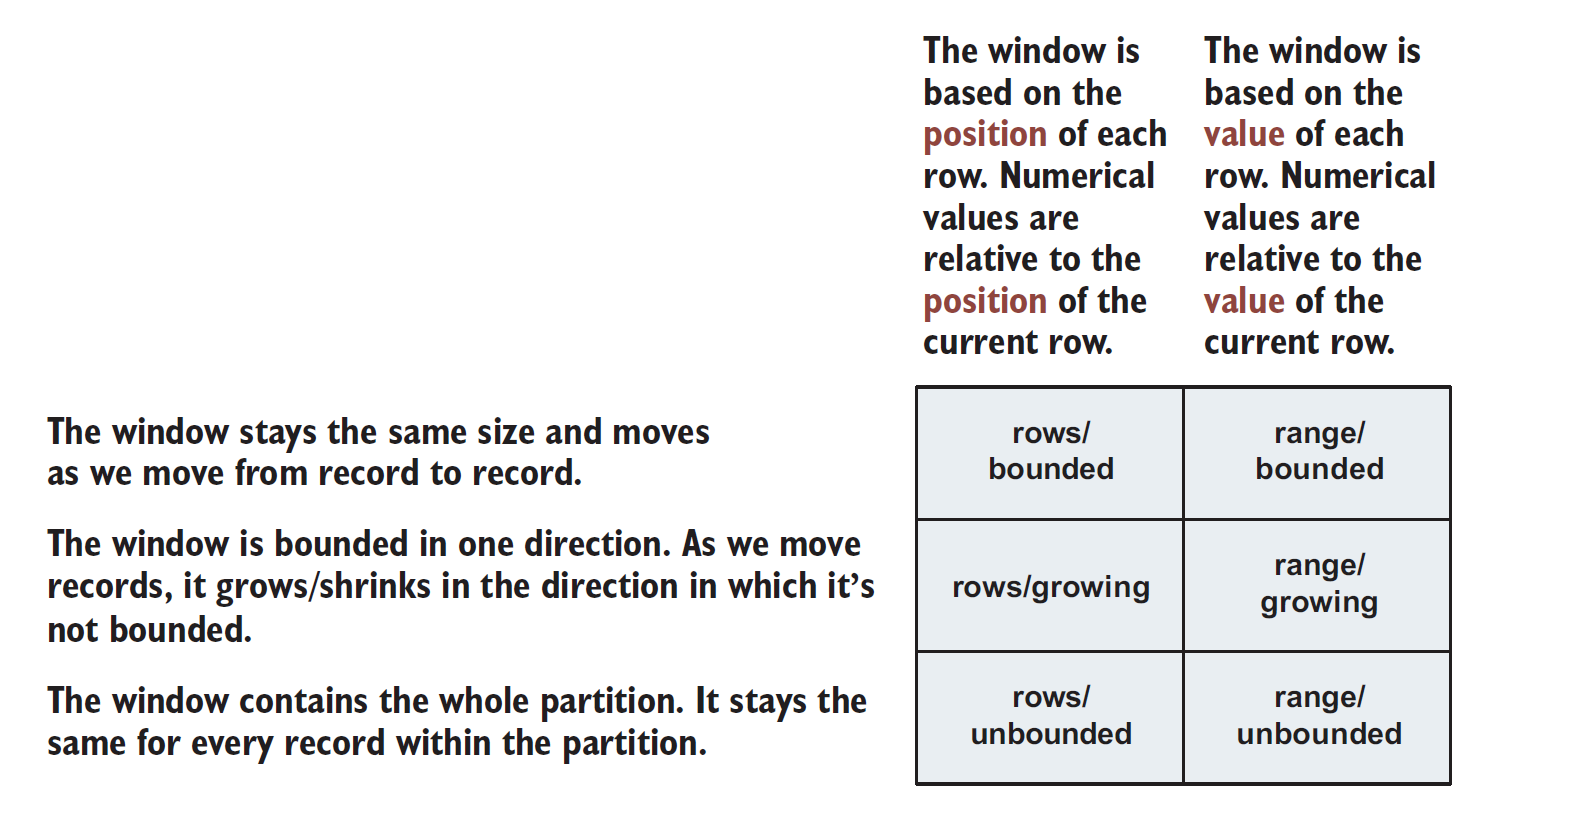

when working with row ranges, you can say only that “X records before and
after.” When using Window.currentRow/unboundedFollowing/unboundedPreceding
with a range window, Spark will use the value of the record as the range boundary.

# UDFs within windows

In [43]:
import pandas as pd

# Spark 2.4, use the following
# @F.pandas_udf("double", PandasUDFType.GROUPED_AGG)

@F.pandas_udf("double")
def median(vals: pd.Series) -> float:
    return vals.median()

gsod_light.withColumn(
    "median_temp", median("temp").over(Window.partitionBy("year"))
).withColumn(
    "median_temp_g",
    median("temp").over(
        Window.partitionBy("year").orderBy("mo", "da")
    ),
).show()

+------+----+---+---+----+----------+-----------+-------------+
|   stn|year| mo| da|temp|count_temp|median_temp|median_temp_g|
+------+----+---+---+----+----------+-----------+-------------+
|998012|2017| 03| 02|31.4|        24|       31.4|         31.4|
|719200|2017| 10| 09|60.5|        11|       31.4|        45.95|
|994979|2017| 12| 11|21.3|        21|       31.4|         31.4|
|996470|2018| 03| 12|55.6|        12|       65.0|         55.6|
|917350|2018| 04| 21|82.6|         9|       65.0|         69.1|
|076470|2018| 06| 07|65.0|        24|       65.0|         65.0|
|041680|2019| 02| 19|16.1|        15|      39.75|         16.1|
|998166|2019| 03| 20|34.8|        12|      39.75|        25.45|
|998252|2019| 04| 18|44.7|        11|      39.75|         34.8|
|949110|2019| 11| 23|54.9|        14|      39.75|        39.75|
+------+----+---+---+----+----------+-----------+-------------+



# The main steps to a successful window function

1. What kind of operation do I want to perform? Summarize, rank, or look
ahead/behind.
2. How do I need to construct my window? Should it be bounded or unbounded?
Do I need every record to have the same window value (unbounded), or should
the answer depend on where the record fits within the window (bounded)?
When bounding a window frame, you most often want to order it as well.
3. For bounded windows, do you want the window frame to be set according to the
position of the record (row based) or the value of the record (range based)?
4. Finally, remember that a window function does not make your data frame special.
After your function is applied, you can filter, group by, and even apply
another, completely different, window.

# Exercises


#### 1
Using the following code, first identify the day with the warmest temperature for each
year, and then compute the average temperature. What happens when there are more
than two occurrences?


In [ ]:
each_year = Window.partitionBy("year")
(gsod
    .withColumn("min_temp", F.min("temp").over(each_year))
    .where("temp = min_temp")
    .select("year", "mo", "da", "stn", "temp")
    .orderBy("year", "mo", "da")
.show())

In [45]:
each_year = Window.partitionBy("year")
(gsod
    .withColumn("warmest_temp", F.max("temp").over(each_year))
    .where("temp = warmest_temp")
    .select("year", "mo", "da", "stn", "temp")
    .orderBy("year", "mo", "da")
    .withColumn("avg_temp",F.avg("temp").over(each_year))
.show())

+----+---+---+------+-----+--------+
|year| mo| da|   stn| temp|avg_temp|
+----+---+---+------+-----+--------+
|2010| 06| 13|406760|110.0|   110.0|
|2011| 07| 15|698084|110.0|   110.0|
|2012| 06| 23|408354|110.0|   110.0|
|2012| 07| 20|405510|110.0|   110.0|
|2012| 07| 20|405860|110.0|   110.0|
|2012| 07| 23|691734|110.0|   110.0|
|2012| 08| 01|405820|110.0|   110.0|
|2013| 06| 29|722787|109.8|   109.8|
|2013| 07| 17|404010|109.8|   109.8|
|2013| 07| 20|999999|109.8|   109.8|
|2013| 07| 25|606300|109.8|   109.8|
|2014| 07| 02|403770|110.0|   110.0|
|2014| 09| 05|606450|110.0|   110.0|
|2015| 07| 04|614370|110.0|   110.0|
|2015| 07| 29|403770|110.0|   110.0|
|2015| 08| 19|404010|110.0|   110.0|
|2016| 06| 30|405810|110.0|   110.0|
|2017| 07| 06|403770|110.0|   110.0|
|2017| 07| 24|999999|110.0|   110.0|
|2018| 06| 06|405860|110.0|   110.0|
+----+---+---+------+-----+--------+
only showing top 20 rows



#### 2
How would you create a rank that is full, meaning that each record within a the
temp_per_month_asc has a unique rank, using the gsod_light data frame? For
records with an identical orderBy() value, the order of rank does not matter.


In [47]:
temp_per_month_asc = Window.partitionBy("mo").orderBy("count_temp")

gsod_light.withColumn(
    "rank_tpm", F.rank().over(temp_per_month_asc)
).show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       1|
|998012|2017| 03| 02|31.4|        24|       3|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



We can use row_number():

In [52]:

gsod_light.withColumn(
    "rank_tpm", F.row_number().over(temp_per_month_asc)
).orderBy("mo","count_temp").show()

+------+----+---+---+----+----------+--------+
|   stn|year| mo| da|temp|count_temp|rank_tpm|
+------+----+---+---+----+----------+--------+
|041680|2019| 02| 19|16.1|        15|       1|
|996470|2018| 03| 12|55.6|        12|       1|
|998166|2019| 03| 20|34.8|        12|       2|
|998012|2017| 03| 02|31.4|        24|       3|
|917350|2018| 04| 21|82.6|         9|       1|
|998252|2019| 04| 18|44.7|        11|       2|
|076470|2018| 06| 07|65.0|        24|       1|
|719200|2017| 10| 09|60.5|        11|       1|
|949110|2019| 11| 23|54.9|        14|       1|
|994979|2017| 12| 11|21.3|        21|       1|
+------+----+---+---+----+----------+--------+



#### 3
Take the gsod data frame (not the gsod_light) and create a new column that is True
if the temperature at a given station is maximum for that station and a time window of
seven days (before and after), and False otherwise.

In [53]:
gsod.columns

['stn',
 'wban',
 'year',
 'mo',
 'da',
 'temp',
 'count_temp',
 'dewp',
 'count_dewp',
 'slp',
 'count_slp',
 'stp',
 'count_stp',
 'visib',
 'count_visib',
 'wdsp',
 'count_wdsp',
 'mxpsd',
 'gust',
 'max',
 'flag_max',
 'min',
 'flag_min',
 'prcp',
 'flag_prcp',
 'sndp',
 'fog',
 'rain_drizzle',
 'snow_ice_pellets',
 'hail',
 'thunder',
 'tornado_funnel_cloud']

In [67]:
SEVEN_DAYS = 7*24*60*60
temp_per_st = Window.partitionBy("stn").orderBy("dt_num").rangeBetween(-SEVEN_DAYS, SEVEN_DAYS)



gsod_days = (gsod
    .withColumn(
        "dt",
        F.to_date(
            F.concat_ws("-",F.col("year"),F.col("mo"),F.col("da"))
        )
    )
    .withColumn("dt_num",F.unix_timestamp("dt"))
).select("year", "mo", "da", "stn", "temp","count_temp","dt","dt_num")

In [68]:
gsod_max = gsod_days.withColumn(
    "max",F.max("temp").over(temp_per_st)
).where("temp = max")

In [69]:
gsod_max.show()

+----+---+---+------+----+----------+----------+----------+----+
|year| mo| da|   stn|temp|count_temp|        dt|    dt_num| max|
+----+---+---+------+----+----------+----------+----------+----+
|2013| 07| 03|007041|83.8|         5|2013-07-03|1372809600|83.8|
|2010| 10| 07|010060|38.4|        24|2010-10-07|1286409600|38.4|
|2010| 10| 19|010060|30.0|        17|2010-10-19|1287446400|30.0|
|2010| 11| 16|010060|19.3|        16|2010-11-16|1289865600|19.3|
|2010| 11| 29|010060|21.1|        24|2010-11-29|1290988800|21.1|
|2010| 12| 16|010060|28.2|        23|2010-12-16|1292457600|28.2|
|2011| 01| 08|010060| 8.7|        24|2011-01-08|1294444800| 8.7|
|2011| 01| 21|010060|26.9|        24|2011-01-21|1295568000|26.9|
|2011| 02| 26|010060|34.8|        24|2011-02-26|1298678400|34.8|
|2011| 03| 17|010060|36.6|        22|2011-03-17|1300320000|36.6|
|2011| 04| 16|010060|27.5|        24|2011-04-16|1302912000|27.5|
|2011| 04| 24|010060|36.3|        24|2011-04-24|1303603200|36.3|
|2011| 05| 02|010060|36.5